In [5]:
from prismo import PRISMO
import plotnine as p9
import pandas as pd
import numpy as np
import enrichrpy.enrichr as een
import enrichrpy.plotting as epl
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from data_loader import load_xenium_breast_cancer
import scanpy as sc

In [6]:
# load and preprocess data
data = load_xenium_breast_cancer()
sc.pp.highly_variable_genes(data["group_chromium"]["rna"], subset=True)

# change var_names from Ensemble ID to gene symbol
data["group_chromium"]["rna"].var_names = (data["group_chromium"]["rna"].var["symbol"].astype(str))
data["group_xenium"]["rna"].var_names = (data["group_xenium"]["rna"].var["symbol"].astype(str))

# convert sparse arrays to dense
data["group_chromium"]["rna"].X = data["group_chromium"]["rna"].X.toarray()
data["group_xenium"]["rna"].X = data["group_xenium"]["rna"].X.toarray()

# convert obs to string
data["group_chromium"]["rna"].obs = data["group_chromium"]["rna"].obs.astype(str)
data["group_xenium"]["rna"].obs = data["group_xenium"]["rna"].obs.astype(str)

In [10]:
model = PRISMO.load("uninformed_10_factors")

/data/florin/prismo_project/prismo/src/prismo/io.py:240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [7]:
w_df = pd.DataFrame(model[0]["weights"]["mean"]["rna"].T)
w_df.columns = [f"Factor {i+1}" for i in range(w_df.shape[1])]
w_df.index = model[0]["feature_names"]["rna"]

w_df

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10
A2M,1.171997,0.786086,0.000000,0.000000,0.714807,0.914952,0.000000,0.017254,0.843705,0.000000
AASS,0.045763,0.008746,0.000000,0.060636,0.150047,0.000000,0.000000,0.000000,0.384142,0.000000
ABCA1,0.960664,0.305597,0.000000,0.000000,0.163919,0.914563,0.000000,0.271170,0.194371,0.000000
ABCA10,0.092235,0.000000,0.000000,0.065434,0.190824,0.000000,0.000000,0.000000,0.597101,0.000000
ABCA5,0.000000,0.141301,0.300136,0.084729,0.036529,0.000000,0.172334,0.166330,0.167600,0.324384
...,...,...,...,...,...,...,...,...,...,...
ZNF562,0.305274,0.312959,0.095533,0.426232,0.183636,0.233263,0.622111,0.139895,0.000000,0.065091
ZNF575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ZNF683,0.000000,0.000000,0.337585,0.000000,0.000000,0.000000,0.178481,0.000000,0.000000,0.460118
ZNF831,0.000000,0.000000,0.112941,0.000000,0.000000,0.000000,0.060555,0.000000,0.000000,0.180119


In [12]:
plots = {}
dfs = {}
for factor_name in w_df.columns:
    w_df_factor = w_df[factor_name]
    inds = w_df_factor > 0.1
    genes = list(w_df[inds].index)
    dfs[factor_name] = een.get_pathway_enrichment(genes, gene_set_library='MSigDB_Hallmark_2020')
    plots[factor_name] = epl.enrichment_barplot(dfs[factor_name], n=20)

In [11]:
combined_chart = alt.concat(*list(plots.values()), columns=5)

combined_chart

alt.ConcatChart(...)

In [20]:
ere = []
erl = []

for factor in dfs.keys():
    ere.append(dfs[factor][dfs[factor]["Term name"] == "Estrogen Response Early"])
    erl.append(dfs[factor][dfs[factor]["Term name"] == "Estrogen Response Late"])

ere = pd.concat(ere)
ere["factor"] = list(dfs.keys())
erl = pd.concat(erl)
erl["factor"] = list(dfs.keys())

In [28]:
ere[ere["Adjusted p-value"] < 0.05]

,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value,factor
11,12,Estrogen Response Early,6.475329e-10,5.028206,106.386032,"[MAST4, SLC2A1, AREG, PRSS23, GJA1, MUC1, CCND...",2.440701e-09,0,0,Factor 2
5,6,Estrogen Response Early,9.761686e-11,6.367627,146.773625,"[EGR3, MAST4, IGFBP4, KRT8, SLC2A1, KAZN, FOS,...",7.158570e-10,0,0,Factor 4
13,14,Estrogen Response Early,3.849928e-09,4.423404,85.704392,"[MAST4, PRSS23, GJA1, MUC1, CCND1, OLFML3, POD...",1.374974e-08,0,0,Factor 5
18,19,Estrogen Response Early,4.295847e-04,2.563132,19.871169,"[TIPARP, KRT8, SLC2A1, FOS, KLF4, DHRS3, TIAM1...",1.062657e-03,0,0,Factor 6
5,6,Estrogen Response Early,2.710401e-07,3.726297,56.345339,"[FCMR, BCL11B, MAST4, TIPARP, KRT8, SLC2A1, AR...",1.626240e-06,0,0,Factor 7
22,23,Estrogen Response Early,1.012877e-02,1.926168,8.845687,"[SVIL, IGFBP4, KAZN, FOS, PRSS23, DHRS3, GJA1,...",2.201906e-02,0,0,Factor 9
18,19,Estrogen Response Early,1.572035e-02,1.865937,7.748861,"[SVIL, FCMR, CLIC3, BCL11B, TIPARP, AQP3, RASG...",4.054197e-02,0,0,Factor 10


In [29]:
erl[erl["Adjusted p-value"] < 0.05]

,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value,factor
8,9,Estrogen Response Late,2.218954e-11,5.513974,135.265493,"[SERPINA3, SERPINA1, LAMC2, PRSS23, AREG, CXCL...",9.884431e-11,0,0,Factor 2
6,7,Estrogen Response Late,6.223070e-10,6.027933,127.777637,"[TOP2A, EGR3, IGFBP4, FOS, KLF4, PRSS23, AREG,...",3.911644e-09,0,0,Factor 4
15,16,Estrogen Response Late,1.139547e-06,3.635530,49.751799,"[SERPINA3, EGR3, IGFBP4, ATP2B4, LAMC2, FOS, K...",3.351608e-06,0,0,Factor 5
16,17,Estrogen Response Late,1.547452e-04,2.716652,23.835176,"[TOP2A, SERPINA3, SERPINA1, FOS, KLF4, TIAM1, ...",4.186713e-04,0,0,Factor 6
13,14,Estrogen Response Late,1.246397e-05,3.191663,36.042394,"[TOP2A, ATP2B4, PRSS23, AREG, CXCL14, ASS1, BA...",4.273360e-05,0,0,Factor 7
19,20,Estrogen Response Late,1.375119e-02,1.982422,8.497909,"[TOP2A, CLIC3, SERPINA1, FOS, KLF4, ISG20, ZFP...",3.231530e-02,0,0,Factor 8


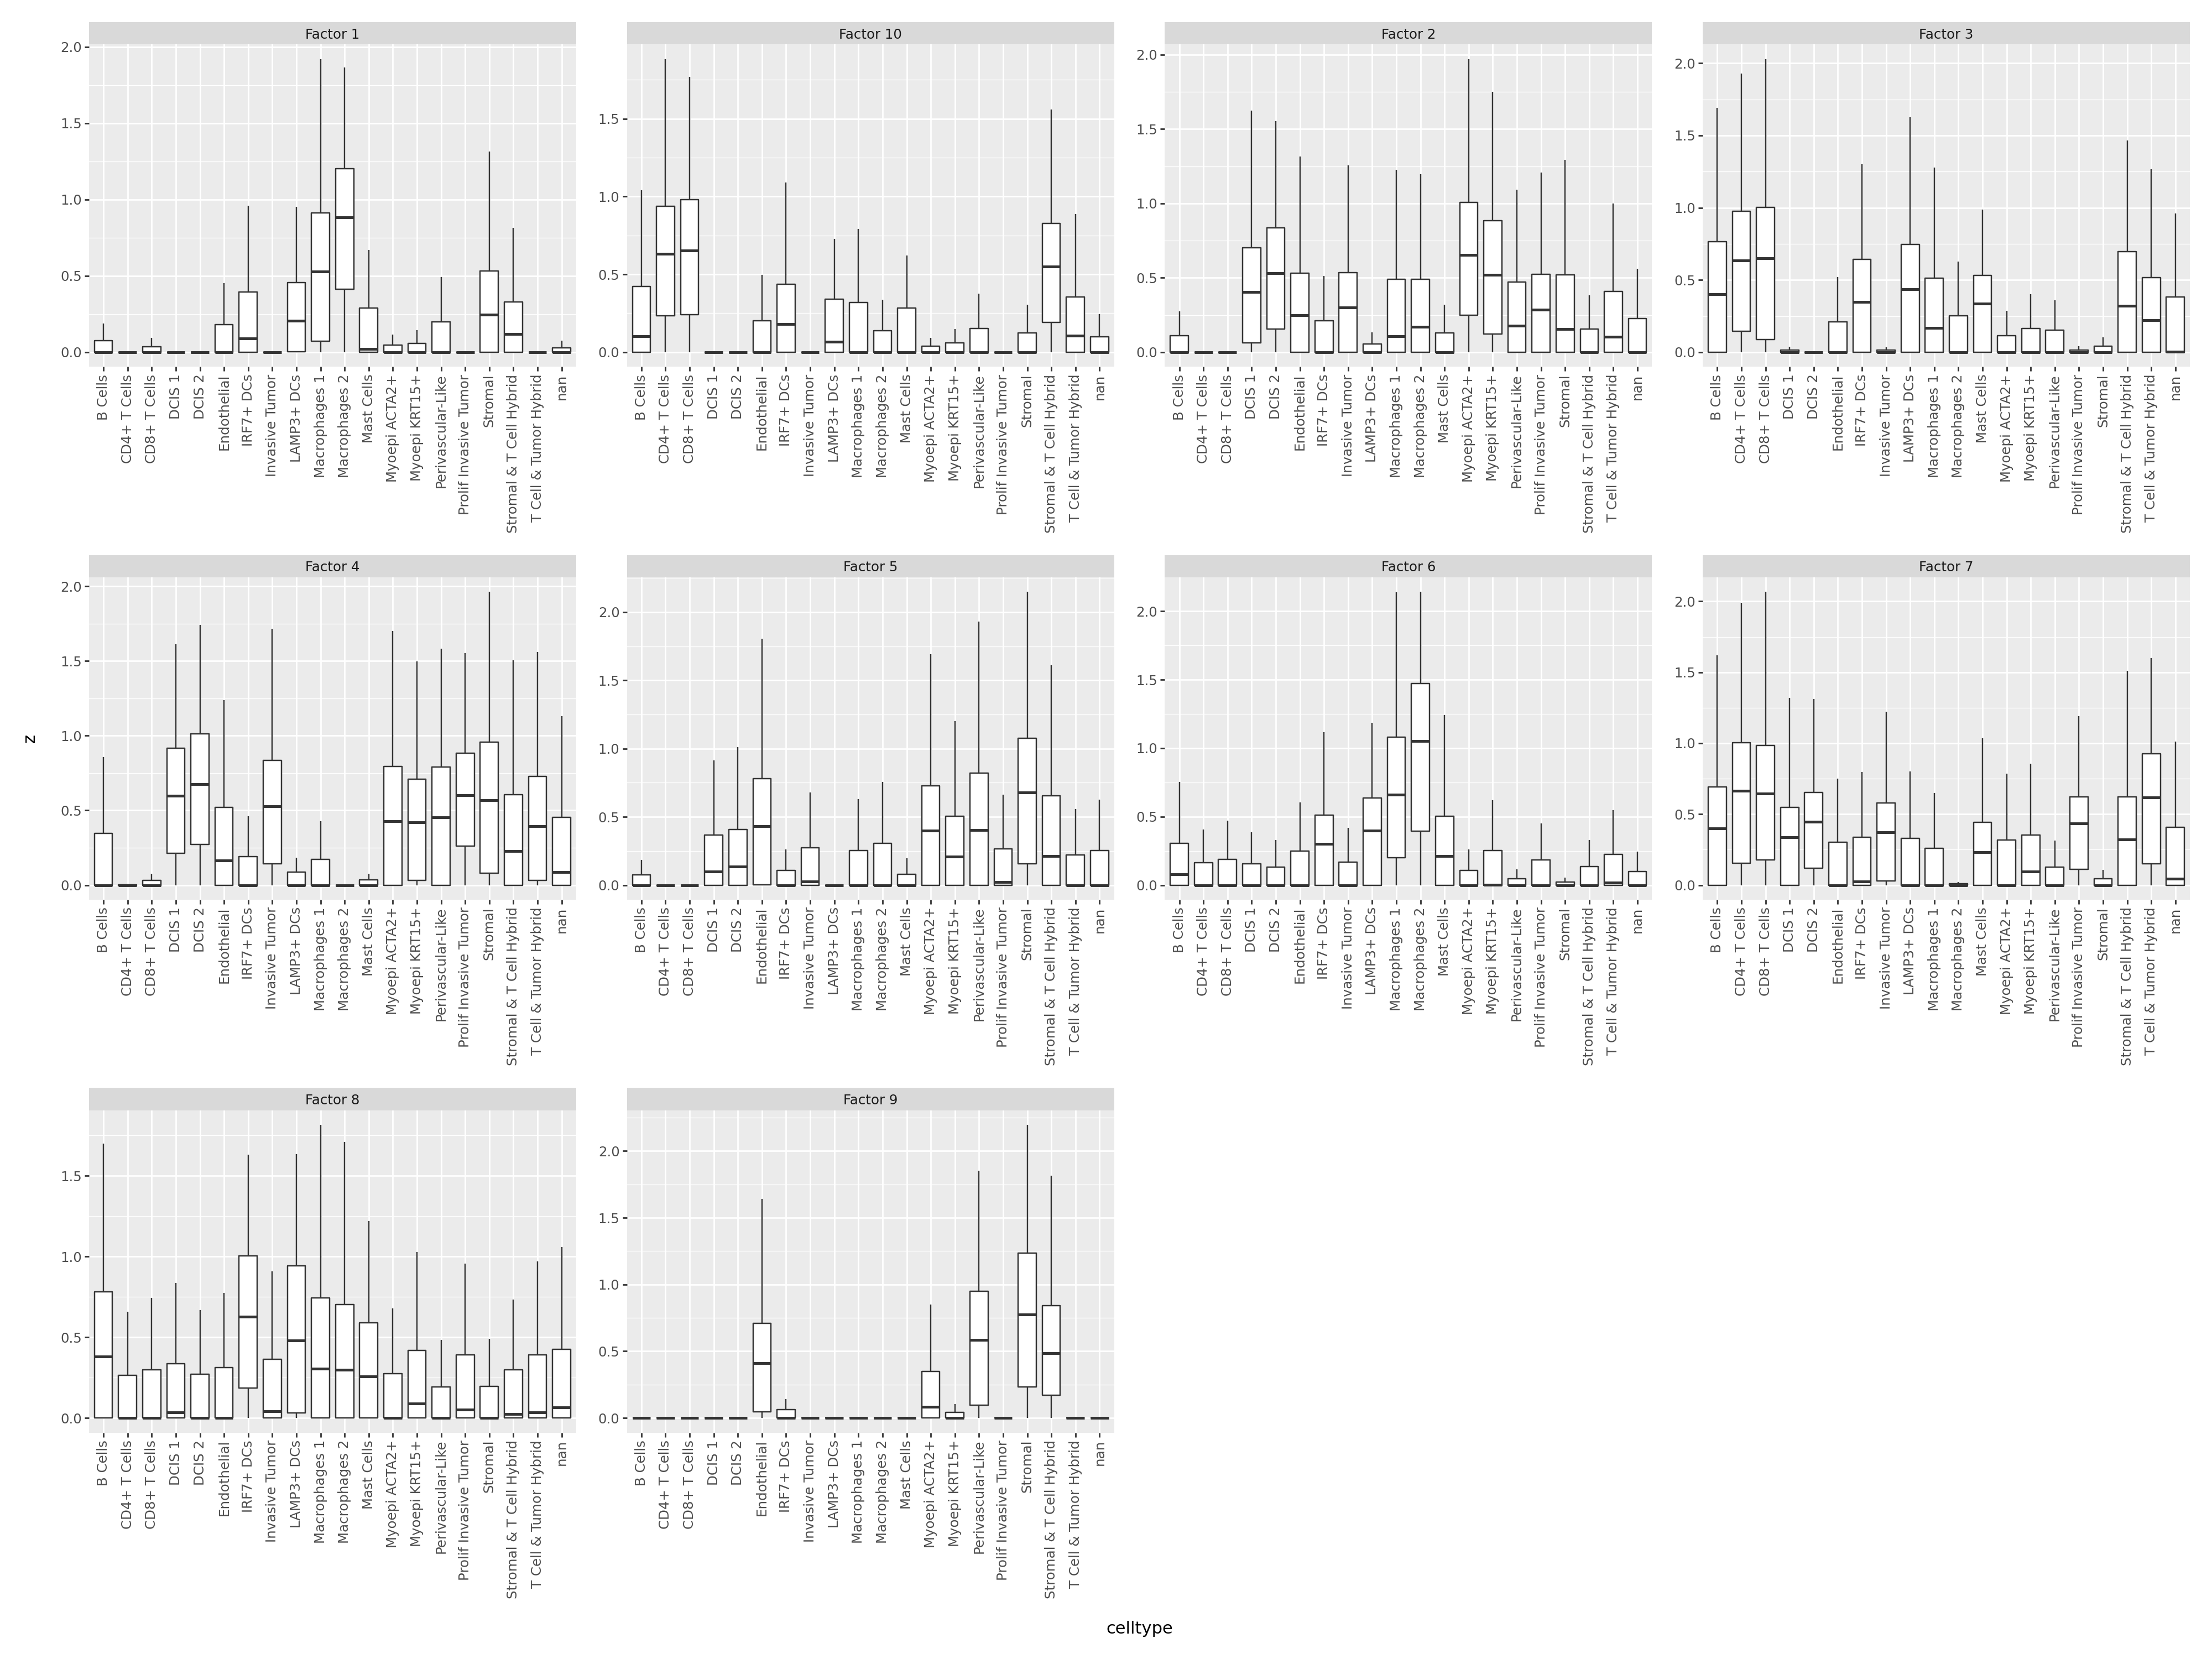

In [47]:
z_chromium_df = pd.DataFrame(model[0]['factors']['mean']['group_chromium'].T)
z_chromium_df.columns = [f"Factor {i+1}" for i in range(z_chromium_df.shape[1])]

z_chromium_df["celltype"] = model[0]["metadata"]['group_chromium']['rna']['celltype'].values

# melt dataframe for plotting
z_chromium_df_long = z_chromium_df.melt(id_vars="celltype", var_name="factor", value_name="z")

plot = (
    p9.ggplot(z_chromium_df_long, p9.aes(x="celltype", y="z"))
    + p9.geom_boxplot(outlier_shape="")
    + p9.facet_wrap("~factor", scales="free")
    + p9.theme(figure_size=(20, 15), axis_text_x=p9.element_text(rotation=90))
)
plot.show()

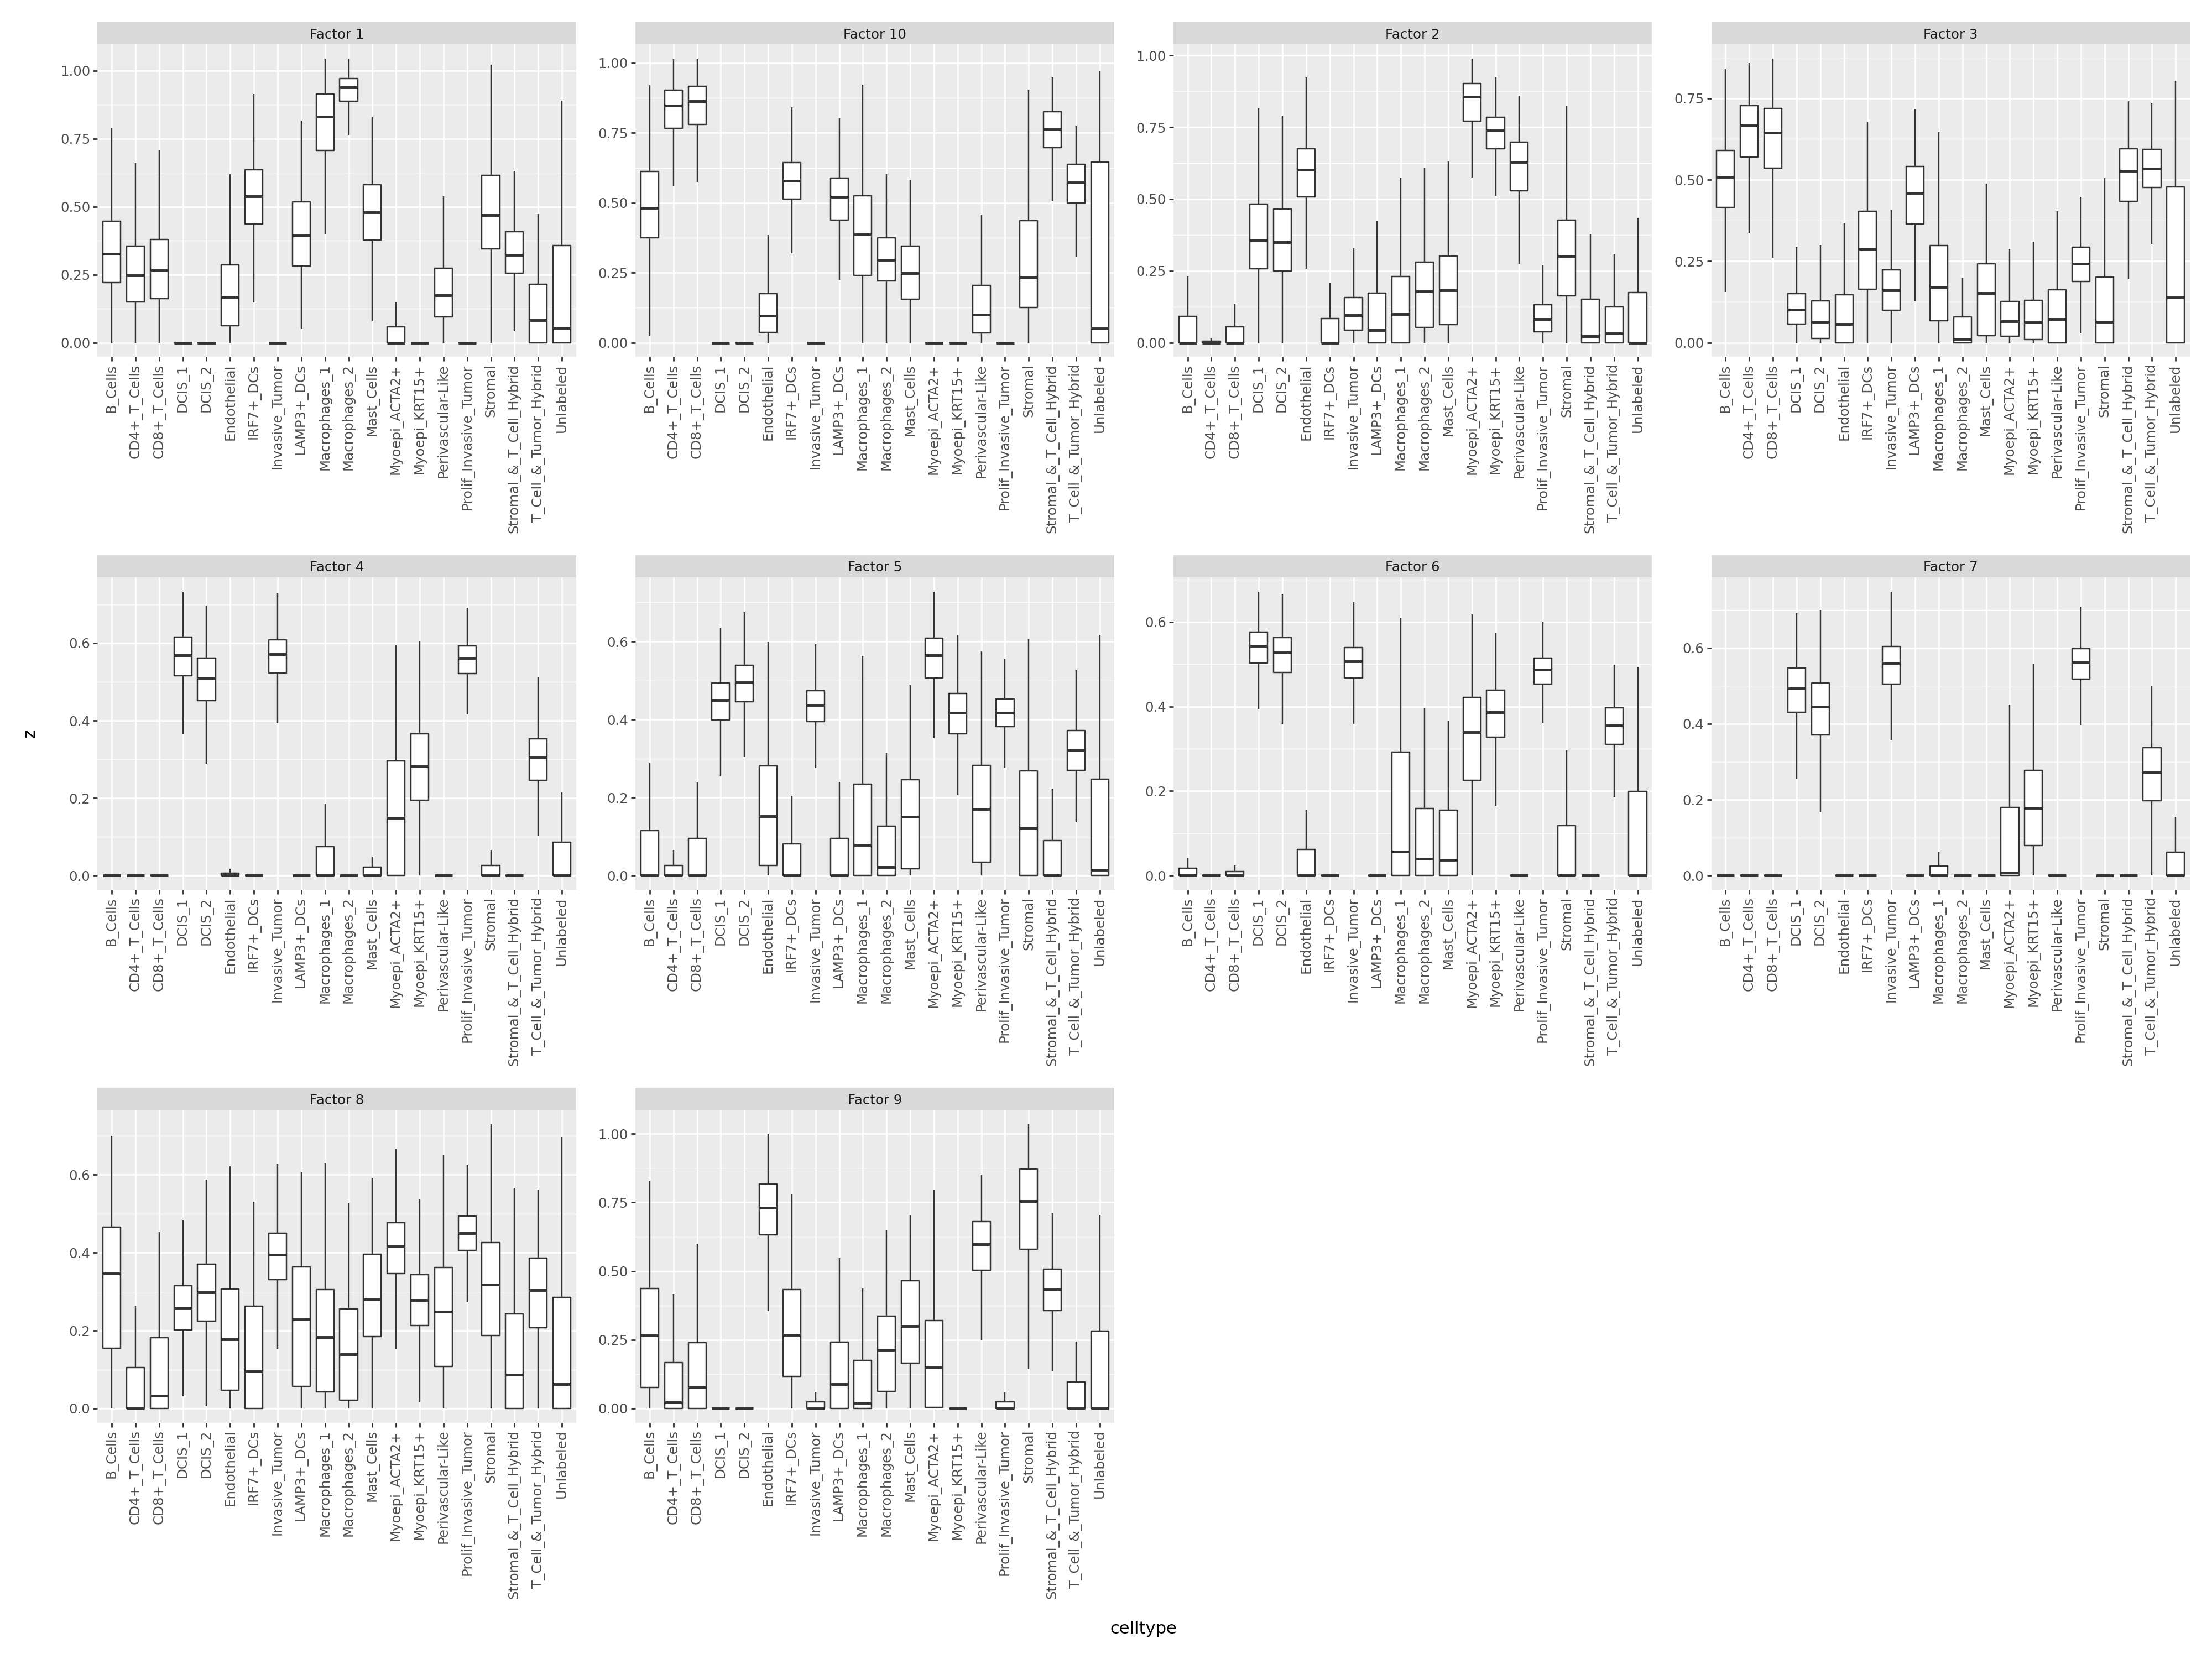

In [48]:
z_xenium_df = pd.DataFrame(model[0]['factors']['mean']['group_xenium'].T)
z_xenium_df.columns = [f"Factor {i+1}" for i in range(z_xenium_df.shape[1])]

z_xenium_df["celltype"] = model[0]["metadata"]['group_xenium']['rna']['celltype'].values

# melt dataframe for plotting
z_xenium_df_long = z_xenium_df.melt(id_vars="celltype", var_name="factor", value_name="z")

plot = (
    p9.ggplot(z_xenium_df_long, p9.aes(x="celltype", y="z"))
    + p9.geom_boxplot(outlier_shape="")
    + p9.facet_wrap("~factor", scales="free")
    + p9.theme(figure_size=(20, 15), axis_text_x=p9.element_text(rotation=90))
)
plot.show()

In [1]:
import h5py

In [2]:
f = h5py.File("xenium_human_breast_cancer_analysis.h5ad")

In [3]:
f.keys()

<KeysViewHDF5 ['X', 'layers', 'obs', 'obsm', 'obsp', 'uns', 'var', 'varm', 'varp']>

In [10]:
list(f["obs"].keys())[-100:]

['Sbpl_ligand_receptor_target_gene_GP',
 'Sct_ligand_receptor_target_gene_GP',
 'Sdc4_ligand_receptor_target_gene_GP',
 'Sele_ligand_receptor_target_gene_GP',
 'Sell_ligand_receptor_target_gene_GP',
 'Sema3f_ligand_receptor_target_gene_GP',
 'Sema3g_ligand_receptor_target_gene_GP',
 'Sema4d_ligand_receptor_target_gene_GP',
 'Sema4f_ligand_receptor_target_gene_GP',
 'Sema6d_ligand_receptor_target_gene_GP',
 'Sfrp1_ligand_receptor_target_gene_GP',
 'Sfrp2_ligand_receptor_target_gene_GP',
 'Sftpa1_ligand_receptor_target_gene_GP',
 'Shbg_ligand_receptor_target_gene_GP',
 'Siglec1_ligand_receptor_target_gene_GP',
 'Siglece_ligand_receptor_target_gene_GP',
 'Siglech_ligand_receptor_target_gene_GP',
 'Sirpa_ligand_receptor_target_gene_GP',
 'Sirpb1a_ligand_receptor_target_gene_GP',
 'Sis_ligand_receptor_target_gene_GP',
 'Slamf7_ligand_receptor_target_gene_GP',
 'Slc6a8_ligand_receptor_target_gene_GP',
 'Slpi_ligand_receptor_target_gene_GP',
 'Sorl1_ligand_receptor_target_gene_GP',
 'Sostdc1_

In [14]:
f["obs"]["niche"]["categories"]
f.close()

In [15]:
import anndata as ad

adata = ad.read_h5ad("xenium_human_breast_cancer_analysis.h5ad")

In [18]:
adata.obs["niche"]

1-Rep_1         Epi-Immune
2-Rep_1         Epi-Immune
4-Rep_1         Epi-Immune
5-Rep_1         Epi-Immune
7-Rep_1         Epi-Immune
                   ...    
118748-Rep_2    FB-Myeloid
118749-Rep_2    FB-Myeloid
118750-Rep_2    FB-Myeloid
118751-Rep_2    FB-Myeloid
118752-Rep_2    FB-Myeloid
Name: niche, Length: 282363, dtype: category
Categories (14, object): ['FB-Epi', 'CD4+T', 'EMT-Immune', 'Epi-Immune', ..., 'EMT-Endo', 'Epi-Bcells', 'Stromal', 'Endo-Lymphoid']

In [22]:
adata[adata.obs["replicates"] == "Rep_1"].obs

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,replicates,...,Add-on_93_GP,Add-on_94_GP,Add-on_95_GP,Add-on_96_GP,Add-on_97_GP,Add-on_98_GP,Add-on_99_GP,cell_type,latent_leiden_0.2,niche
1-Rep_1,1,847.259912,326.191365,28,1,0,28.0,58.387031,26.642187,Rep_1,...,0.090188,0.255087,-6.994426,-0.176177,-21.836824,-1.172290,-0.767473,B_cells,3,Epi-Immune
2-Rep_1,2,826.341995,328.031830,94,0,0,94.0,197.016719,42.130781,Rep_1,...,0.059390,0.354749,-12.176075,-0.258173,-20.680340,0.837346,-1.081718,EMT,3,Epi-Immune
4-Rep_1,4,824.228409,334.252643,11,0,0,11.0,42.311406,10.069844,Rep_1,...,-0.050650,0.365285,-11.477331,-0.158223,-19.374250,-1.070270,-0.998882,B_cells,3,Epi-Immune
5-Rep_1,5,841.357538,332.242505,48,0,0,48.0,107.652500,37.479687,Rep_1,...,0.065690,0.343956,-6.261610,-0.227737,-17.298460,0.135013,-0.945750,B_cells,3,Epi-Immune
7-Rep_1,7,835.284583,338.135696,10,0,0,10.0,56.851719,17.701250,Rep_1,...,-0.019145,0.440225,-4.722423,-0.282764,-16.710651,0.912710,-1.205152,B_cells,3,Epi-Immune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167776-Rep_1,167776,7455.475342,5114.875415,229,1,0,229.0,220.452812,60.599688,Rep_1,...,0.131426,-0.118104,-7.152846,-0.043803,-12.117313,-1.593488,-0.128502,EMT,2,EMT-Immune
167777-Rep_1,167777,7483.727051,5111.477490,79,0,0,79.0,37.389375,25.242344,Rep_1,...,0.157254,-0.156995,-4.006928,-0.009998,-16.079916,-1.109943,-0.105862,EMT,2,EMT-Immune
167778-Rep_1,167778,7470.159424,5119.132056,397,0,0,397.0,287.058281,86.700000,Rep_1,...,0.110760,-0.102168,-4.243927,-0.036843,-8.608075,-1.891601,-0.103840,EMT,2,EMT-Immune
167779-Rep_1,167779,7477.737207,5128.712817,117,0,0,117.0,235.354375,25.197187,Rep_1,...,0.112932,-0.158458,-4.912245,0.050448,-10.098997,6.167796,-0.009754,EMT,2,EMT-Immune
